### Проект выполнил
Ф.И.О Мирошкин Ярослав Андреевич <br>
Telegram - https://t.me/MiroshkinYaroslav

## Описание проекта

## Цели

## Описание данных

# English Score


In [1]:
import os
import pysrt as srt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pickle
import pprint
import re
import tensorflow as tf

import lightgbm as lgb

import nltk
from nltk.corpus import stopwords

from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import  KNeighborsClassifier

from transformers import TFAutoModel, AutoTokenizer

from datasets import load_dataset



nltk.download('stopwords')
nltk.download('punkt')

STATE = 0


c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(cm)
    cmp.plot()


In [3]:
def my_bar(data: pd.Series, dropna=True, title='', xlabel='', ylabel=''):
    distribution = data.value_counts(dropna=dropna, normalize=False)
    distribution_normalized = data.value_counts(dropna=dropna, normalize=True)
    _, ax = plt.subplots(1)
    sns.barplot(x=distribution_normalized.index, y=distribution_normalized.values).set(
    title=title, xlabel=xlabel, ylabel=ylabel)
    for a, p in enumerate(ax.patches):
        text = str(distribution.iloc[a])
        ax.annotate(text, xy=(p.get_x() + p.get_width() / 2, 0.8 * p.get_height()), \
        size=13, color='black', ha = 'center', va = 'center',
        bbox = dict(boxstyle = 'round',\
        facecolor='none',edgecolor='black', alpha = 0.5) )

def my_kde(df: pd.DataFrame(), col=''):
    f, (ax_kde, ax_box) = plt.subplots(2, gridspec_kw={"height_ratios": (0.85, 0.15)}, sharex=True)
    sns.kdeplot(df, alpha=0.3, fill=True, color='green', ax=ax_kde)
    ax_kde.set(xlabel='', yticks=[])
    ax_kde.set_title(col, fontsize=16)
    sns.boxplot(data=df, orient='h', ax=ax_box, color='green')
    plt.subplots_adjust(hspace=0)
    ax_box.set_xlabel('')

### Парсинг данных и чтение данных

In [4]:
movies_labels = pd.read_excel('english_scores\movies_labels.xlsx', index_col='Movie').drop('id', axis=1)
paths = ['english_scores/subtitles_all/subtitles/',
         'english_scores/subtitles_all/A2/',
         'english_scores/subtitles_all/B1/',
         'english_scores/subtitles_all/B2/',
         'english_scores/subtitles_all/C1/',
         'subtitles/']
data = {}
for path in paths:
    for sub_name in os.listdir(path[:-1]):
        try:
            subs = srt.open(path + sub_name, encoding='utf-8')
        except:
            subs = srt.open(path + sub_name, encoding='ISO-8859-1')
        sub_list = " ".join([sub.text for sub in subs])
        data[sub_name[:-4]] = sub_list


In [5]:
df = pd.DataFrame(data.values(), index=data.keys(), columns=['subtitle'])
df.head(3)

,subtitle
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here..."
Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac..."


Получен датасет, где:<br>
индексы - названия фильмов<br>
subtitle - субтитры в строков формате <br><br>
Оценим общее количество символов в "сыром датасете"

In [6]:
print(f'Общее количество символов в субтитрах: {df.subtitle.str.len().sum():,.0f}')

Общее количество символов в субтитрах: 11,277,626


### Добавление и обработка разметки

Добавим в датасет разметку

In [7]:
movies_labels.head(3)

,Level
Movie,
10_Cloverfield_lane(2016),B1
10_things_I_hate_about_you(1999),B1
A_knights_tale(2001),B2


In [8]:
print(f'Количество файлов субтитров: {df.subtitle.count()}\n\
Количество строк в разметке: {movies_labels.Level.count()}')

Количество файлов субтитров: 279
Количество строк в разметке: 241


Часть данных не размечена

In [9]:
df = df.join(movies_labels)
df = df.rename(columns={'Level': 'level'})
df.head(2)

,subtitle,level
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz...",B1
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here...",B1


Проанализируем баланс классов в `level`

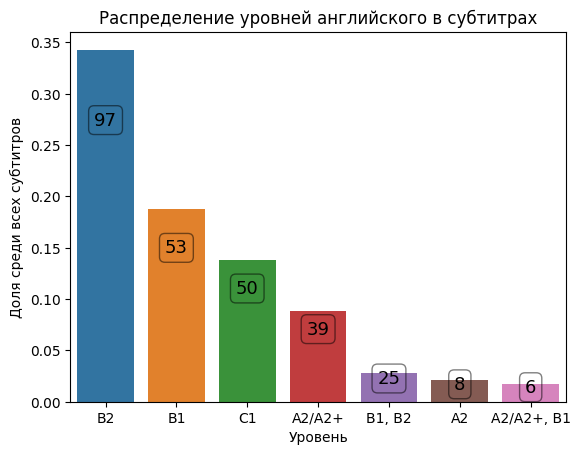

In [10]:
my_bar(df.level, dropna=False, title='Распределение уровней английского в субтитрах',\
        xlabel='Уровень', ylabel='Доля среди всех субтитров')

Оставим 4 основных уровня знания языка:
* A2, A2+ - Beginner, Elementary 
* B1 - Intermediate 
* B2 - Upper-Intermediate 
* C1 - Advanced


In [11]:
df = df.replace({'level' :{'B1, B2': 'B1',
                      'A2': 'A2/A2+',
                      'A2/A2+, B1': 'A2/A2+'}})

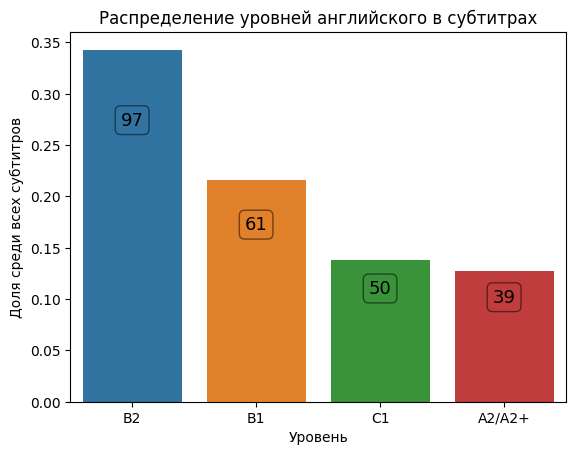

In [12]:
my_bar(df.level, dropna=False, title='Распределение уровней английского в субтитрах',\
        xlabel='Уровень', ylabel='Доля среди всех субтитров')

Присутствует дисбаланс классов <br><br>
Удалим неразмеченные данные

In [13]:
df = df.dropna(subset='level', axis=0)

Заменим уровни знания языка числовыми параметрами в порядке возрастания.
* A2, A2+ - 0
* B1 - 1
* B2 - 2 
* C1 - 3

In [14]:
df.level = df.level.replace({'A2/A2+': 0,
                  'B1': 1,
                  'B2': 2,
                  'C1': 3})

### Обработка данных

#### Приведение к нижнему регистру, обработка спецсимволов и "стоп-слов"

In [15]:
# Пример "стоп-слов"
np.array(stopwords.words('english'))[:20]

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his'], dtype='<U10')

In [16]:
def preprocess_text(data, stopwords=stopwords.words('english')):
    #Приводим к нижему регистру
    text = data.lower()
    #Удаляем все символы между <>, '<some symbols>' -> ''
    text = re.sub('<[^>]+>', '', text)
    #Добавляем пробелы между знаками препинания
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # удаляем пробелы в начале и в конце предложения
    text = text.strip()
    #Удаляем слова в скобках
    text = re.sub(r'\([^)]*\)', '', text)
    # Оставляем только латинские буквы
    text = re.sub(r'[^a-z]', ' ', text)
    # удаление стоп-слов
    text = [w for w in text.split() if w not in stopwords]
    # удаляем слова короче 3х символов
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)

In [17]:
df.subtitle = df.subtitle.apply(lambda text: preprocess_text(text))

#### Стемминг и лемматизация

In [18]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [19]:
flag = 0
if flag:
    df['lemma_clear_text'] = df.subtitle.apply(lambda row: lemmatize(row))
else:
    with open('df_lemma.pickle', 'rb') as file:
        df = pickle.load(file)

In [20]:
df = df.loc[~(df.lemma_clear_text=='')]

In [21]:
features = df.lemma_clear_text
target = df.level

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target,\
                                 test_size=0.25, random_state=STATE, shuffle=True)

### Оценка количества слов в субтитрах

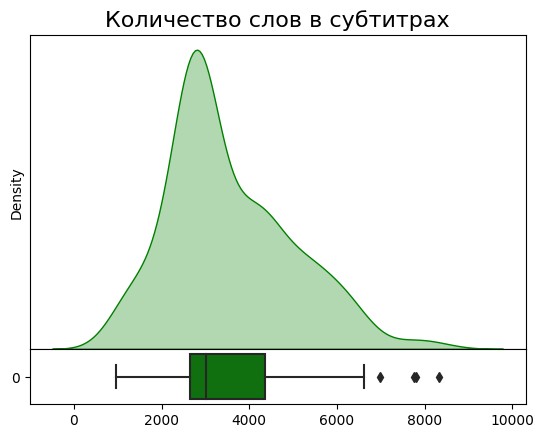

In [23]:
my_kde(df.lemma_clear_text.apply(lambda x: len(x.split())), col='Количество слов в субтитрах')

### Векторизация

In [24]:
corpus_train = X_train.values
corpus_test = X_test.values

In [25]:
tfidf = TfidfVectorizer()
tf_idf_train = tfidf.fit_transform(corpus_train)
tf_idf_test = tfidf.transform(corpus_test)

### Моделирование

LogisticRegression Baseline

In [26]:
lr = LogisticRegression(random_state=STATE, class_weight='balanced')
lr.fit(tf_idf_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

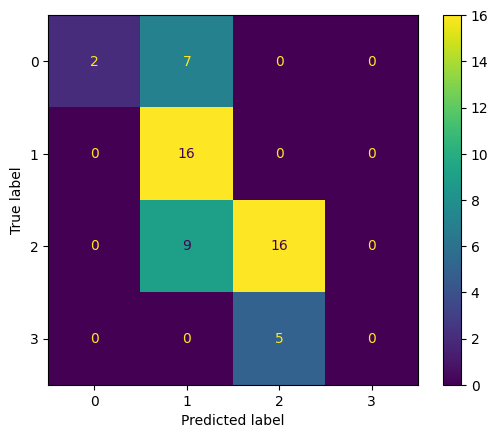

In [27]:
plot_confusion_matrix(y_test, lr.predict(tf_idf_test))

In [28]:
print(classification_report(y_test, lr.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.50      1.00      0.67        16
           2       0.76      0.64      0.70        25
           3       0.00      0.00      0.00         5

    accuracy                           0.62        55
   macro avg       0.57      0.47      0.43        55
weighted avg       0.66      0.62      0.57        55



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

LogisticRegression Tuning

RandomForestClassifier Tuning

In [29]:
rfc = RandomForestClassifier(random_state=STATE, max_depth=15)
rfc.fit(tf_idf_train, y_train);

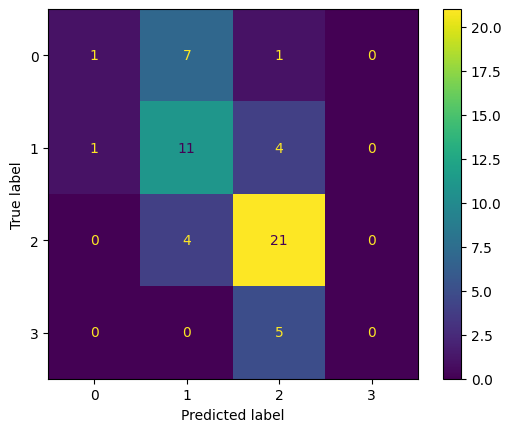

In [30]:
plot_confusion_matrix(y_test, y_pred=rfc.predict(tf_idf_test))

In [31]:
print(classification_report(y_test, y_pred=rfc.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.50      0.69      0.58        16
           2       0.68      0.84      0.75        25
           3       0.00      0.00      0.00         5

    accuracy                           0.60        55
   macro avg       0.42      0.41      0.38        55
weighted avg       0.54      0.60      0.54        55



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

LightGBM Tuning|

In [32]:
lgb_model = lgb.LGBMClassifier(random_state=STATE)
lgb_model.fit(tf_idf_train, y_train)

LGBMClassifier(random_state=0)

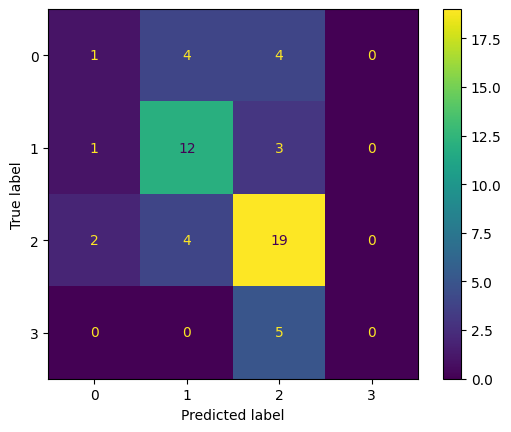

In [33]:
plot_confusion_matrix(y_test, lgb_model.predict(tf_idf_test))

In [34]:
print(classification_report(y_test, lgb_model.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.25      0.11      0.15         9
           1       0.60      0.75      0.67        16
           2       0.61      0.76      0.68        25
           3       0.00      0.00      0.00         5

    accuracy                           0.58        55
   macro avg       0.37      0.41      0.37        55
weighted avg       0.49      0.58      0.53        55



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

CatBoostClassifier

In [37]:
flag = 0
if flag:
    cbc = CatBoostClassifier(random_state=STATE, max_depth=10, iterations=100)
    cbc.fit(tf_idf_train, y_train)
else:
    with open('content/cbc.pickle', 'rb') as file:
        cbc = pickle.load(file)

Learning rate set to 0.5
0:	learn: 1.2573090	total: 5.08s	remaining: 8m 22s
1:	learn: 1.1270286	total: 10.2s	remaining: 8m 18s
2:	learn: 1.0138080	total: 15.2s	remaining: 8m 11s
3:	learn: 0.8998503	total: 20.1s	remaining: 8m 2s
4:	learn: 0.8076931	total: 25s	remaining: 7m 54s
5:	learn: 0.7456847	total: 29.8s	remaining: 7m 46s
6:	learn: 0.6910874	total: 34.6s	remaining: 7m 39s
7:	learn: 0.6582913	total: 39.4s	remaining: 7m 32s
8:	learn: 0.6177372	total: 44.5s	remaining: 7m 29s
9:	learn: 0.5777481	total: 49.2s	remaining: 7m 23s
10:	learn: 0.5355017	total: 54.1s	remaining: 7m 18s
11:	learn: 0.4968470	total: 59s	remaining: 7m 12s
12:	learn: 0.4613959	total: 1m 3s	remaining: 7m 7s
13:	learn: 0.4314290	total: 1m 8s	remaining: 7m 1s
14:	learn: 0.4001626	total: 1m 13s	remaining: 6m 55s
15:	learn: 0.3709643	total: 1m 18s	remaining: 6m 50s
16:	learn: 0.3255772	total: 1m 23s	remaining: 6m 45s
17:	learn: 0.2983229	total: 1m 27s	remaining: 6m 39s
18:	learn: 0.2681255	total: 1m 32s	remaining: 6m 32s

In [39]:
print(classification_report(y_test, cbc.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.60      0.75      0.67        16
           2       0.64      0.84      0.72        25
           3       0.00      0.00      0.00         5

    accuracy                           0.62        55
   macro avg       0.43      0.43      0.39        55
weighted avg       0.55      0.62      0.55        55



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

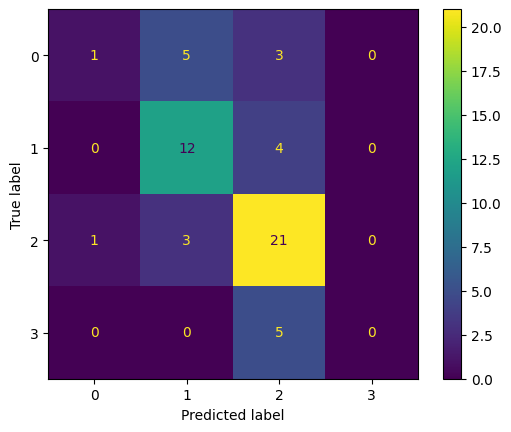

In [40]:
plot_confusion_matrix(y_test, cbc.predict(tf_idf_test))

In [41]:
flag = 0
if flag:
    cbc_gpu = CatBoostClassifier(random_state=STATE, max_depth=8, iterations=200,
                            task_type='GPU')
    cbc_gpu.fit(tf_idf_train, y_train)
else:
    with open('content/cbc_gpu.pickle', 'rb') as file:
        cbc_gpu = pickle.load(file)

Learning rate set to 0.171107
0:	learn: 1.2003567	total: 200ms	remaining: 39.7s
1:	learn: 1.1049638	total: 390ms	remaining: 38.6s
2:	learn: 1.0003722	total: 518ms	remaining: 34s
3:	learn: 0.9293683	total: 677ms	remaining: 33.2s
4:	learn: 0.8529264	total: 810ms	remaining: 31.6s
5:	learn: 0.7934022	total: 967ms	remaining: 31.3s
6:	learn: 0.7418904	total: 1.12s	remaining: 31s
7:	learn: 0.6994490	total: 1.3s	remaining: 31.3s
8:	learn: 0.6539942	total: 1.45s	remaining: 30.8s
9:	learn: 0.6037386	total: 1.6s	remaining: 30.4s
10:	learn: 0.5705635	total: 1.74s	remaining: 29.9s
11:	learn: 0.5301139	total: 1.88s	remaining: 29.5s
12:	learn: 0.5035704	total: 2.04s	remaining: 29.4s
13:	learn: 0.4794461	total: 2.2s	remaining: 29.3s
14:	learn: 0.4624073	total: 2.42s	remaining: 29.8s
15:	learn: 0.4415107	total: 2.56s	remaining: 29.4s
16:	learn: 0.4189561	total: 2.7s	remaining: 29.1s
17:	learn: 0.3989360	total: 2.85s	remaining: 28.8s
18:	learn: 0.3795984	total: 2.99s	remaining: 28.5s
19:	learn: 0.366768

In [44]:
print(classification_report(y_test, cbc_gpu.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.52      0.88      0.65        16
           2       0.79      0.76      0.78        25
           3       1.00      0.40      0.57         5

    accuracy                           0.67        55
   macro avg       0.83      0.56      0.59        55
weighted avg       0.77      0.67      0.65        55



## Text Complexity by words

In [45]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
import numpy as np

class TextComplexity():
    '''
    Return the complexity of a text
    the more complex it is, the higher the number
    
    1. Fit the model on a big text or a list of strings
       The model will create a ranking of the most used words
       (tokens) in the text.
    2. Predict: Calculate the median usage ranking of the words
                in a string
    '''
    
    def __init__(self):
        # The pattern might have to be updated depending
        # on the language
        
        self.tokenizer = RegexpTokenizer('[a-zöäüß]+')
        
    def tokenize(self,text):
        # Tokenize the text
        
        text = text.lower()
        tokens_raw = self.tokenizer.tokenize(text)
        
        # Keep only tokens with at least two letters
        tokens = []
        for t in tokens_raw:
            if len(t)>1:
                tokens.append(t)
            
        return tokens
    
    
    
    def fit(self,X):
        '''Fit the model with a text or a list of strings
        '''
        try:
            object_iterator = iter(X)
        except TypeError as te:
            print('Error: Input X is not iterable.')
            
        if not isinstance(X,str):
            # If X is a list of strings: Join the strings together
            X = " ".join(X)
        
        # Tokenize the text
        tokens = self.tokenize(X)
                
        complete_dic = Counter(tokens)
        
        # Rank the tokens depending on their count
        lst = list(complete_dic.items())
        lst = sorted(lst, key = lambda x: x[1], reverse = True)
        word = [x[0] for x in lst]
        word_count = [x[1] for x in lst]
        self.df = pd.DataFrame({'word':word, 'word_count': word_count})
        rank_dict = self.df.to_dict()
        self.rank_word = {v:k for k,v in rank_dict['word'].items()}
        
        self.corpus = list(self.rank_word.keys()) # List of the corpus
        self.corpus_len = len(self.corpus) # The number of distinct tokens in the corpus
        self.number_words = len(tokens) # The total number of tokens
        
        return None
      
        
    def predict(self, X, topn = 100):
        '''
        Predict: Calculate the median usage ranking of the words
                 in a string
                 
        Input: 
            X (string or list of strings)
            topn (int): The % of words in the top-n most frequent words
        '''
        
        try:
            object_iterator = iter(X)
        except TypeError as te:
            print('Error: Input X is not iterable.')
        
        if not isinstance(X,str):
            # If X is a list of strings: Join the strings together
            X = " ".join(X)
            
        # Tokenize the text
        tokens = self.tokenize(X)

        # Create a list with the rank of each token
        lst_rank = []
        for t in tokens:
            if t in self.rank_word:
                lst_rank.append(self.rank_word[t])
                
                # If the following part is ignored
                # the tokens not in the corpus will be ignored
                
#             else: 
                # If a token isn't in the corpus
                # add to the list the highest rank (corpus length)
#                 lst_rank.append(self.corpus_len)
        median = int(np.median(lst_rank))
        percent_topn = sum([t < topn for t in lst_rank]) / len(lst_rank)

        return median, percent_topn, lst_rank

In [46]:
with open('oxford/The_Oxford_3000_by_CEFR_level.txt', 'r') as file:
    words = file.read().split()
    a12_words = words[words.index('A1') + 5:words.index('B1')]
    b1_words = words[words.index('B1') + 1:]

In [47]:
with open('oxford/The_Oxford_5000_by_CEFR_level.txt', 'r') as file:
    words = file.read().split()
    b2_words = words[words.index('B2') + 5:words.index('C1')]
    c1_words = words[words.index('C1') + 1:]

In [48]:
my_stop_words = ['indefinite', 'article', 'modal']
def prepare_words(words: list) -> list:
    words = [w for w in words if '.' not in w]
    words = [w for w in words if len(w) >= 3]
    words = [w for w in words if w not in my_stop_words]
    return words

In [49]:
a12_words = prepare_words(a12_words)
b1_words = prepare_words(b1_words)
b2_words = prepare_words(b2_words)
c1_words = prepare_words(c1_words)

In [50]:
tc = {
    'a12' : TextComplexity(),
    'b1' : TextComplexity(),
    'b2' : TextComplexity(),
    'c1' : TextComplexity(),
} 
tc['a12'].fit(a12_words)
tc['b1'].fit(b1_words)
tc['b2'].fit(b2_words)
tc['c1'].fit(c1_words)

In [51]:
p = np.array([])
for i in ['a12', 'b1', 'b2', 'c1']:
    _, temp, _ = tc[i].predict(df.loc['Aladdin(1992)'].subtitle)
    p = np.append(p, temp)

In [52]:
def Complexity(sentence: str) -> int:
    probability = np.array([])
    for i in ['a12', 'b1', 'b2', 'c1']:
        _, p, _ = tc[i].predict(sentence)
        probability = np.append(probability, p)
    return probability.argmax()

In [55]:
y_pred = df.lemma_clear_text.apply(lambda text: Complexity(text))

In [57]:
print(classification_report(df.level, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.06      0.10        36
           1       0.00      0.00      0.00        61
           2       0.49      0.60      0.54        97
           3       0.17      0.70      0.28        23

    accuracy                           0.35       217
   macro avg       0.25      0.34      0.23       217
weighted avg       0.29      0.35      0.29       217



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

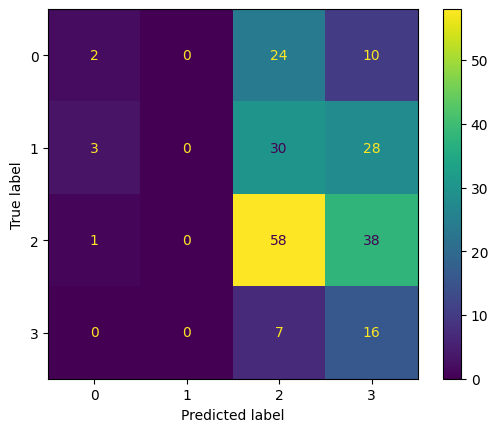

In [59]:
plot_confusion_matrix(df.level, y_pred)

## BERT

In [72]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

In [73]:
model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [74]:
classifier = BertClassifier(
        model_path='bert-base-uncased',
        tokenizer_path='bert-base-uncased',
        n_classes=y_train.nunique(),
        epochs=2,
        model_save_path='content/bert.pt'
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [75]:
classifier.preparation(
        X_train=list(X_train),
        y_train=list(y_train),
        X_valid=list(X_test),
        y_valid=list(y_test)
    )

c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [76]:
%time
classifier.train()

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/2
Train loss 1.3089609173522598 accuracy 0.3850574712643678
Val loss 1.1711469054222108 accuracy 0.5254237288135594
----------
Epoch 2/2
Train loss 1.2307004681092568 accuracy 0.4367816091954023
Val loss 1.1384449392557143 accuracy 0.5254237288135594
----------


In [81]:
y_pred = [classifier.predict(t) for t in X_test]

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        14
           2       0.48      1.00      0.65        26
           3       1.00      0.50      0.67        10

    accuracy                           0.53        59
   macro avg       0.37      0.38      0.33        59
weighted avg       0.38      0.53      0.40        59



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf